# Tracking speed - Benchmarks

In this experiment, we evaluate the tracking performance of:

* MLflow - https://mlflow.org/
* WandB - https://wandb.ai/
* Neptune - https://neptune.ai/
* Aim - https://aimstack.io/
* Comet - https://www.comet.com/
* MLtraq - https://mltraq.com/

Varying:

* Number of experiments tracked
* Number of runs tracked
* Number of values tracked

Configuration:
* Tracking is limited to `int` values, disabling everything else such as git, code, environment and system stats
* Experiments running offline, logging disabled, storage on local filesystem
* Every experiment starts with an empty directory for storage
* Results averaged on `10` runs


## Imports and utility functions

In [1]:
%load_ext pyinstrument

In [2]:
import logging
import shutil
import threading
import uuid
from contextlib import contextmanager, redirect_stderr, redirect_stdout
from os import devnull, environ, makedirs, remove

import aim
import comet_ml
import matplotlib.pyplot as plt
import mlflow
import mltraq
import neptune
import pandas as pd
import wandb
from mltraq.utils.plot import bar_plot

In [3]:
# Versions

print("mlflow", mlflow.__version__)
print("neptune", neptune.__version__)
print("wandb", wandb.__version__)
print("aim", aim.__version__.__version__)
print("comet", comet_ml.__version__)
print("mltraq", mltraq.__version__)

mlflow 2.10.2
neptune 1.9.1
wandb 0.16.3
aim 3.18.1
comet 3.38.0
mltraq 0.0.118


In [4]:
# Utility functions


@contextmanager
def suppress_stdout_stderr():
    """
    A context manager that redirects stdout and stderr to devnull.
    """
    with open(devnull, "w") as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)


def remove_file(pathname):
    """
    Remove file `pathname` if existing.
    """
    try:
        remove(pathname)
    except OSError:
        pass


def create_dir(pathdir):
    """
    Create `pathdir` recursively. If it already exists, do nothing.
    """
    makedirs(pathdir, exist_ok=True)

## Test procedure for WandB

In [5]:
def test_wandb(n_experiments=1, n_runs=1, n_values=1):
    """
    Test Weights & Biases tracking with a specified number of experiments, runs and values.
    """

    # Required to silence Python output and disable sentry tracking.
    # This must be inside the test function to propagate to child processes.
    environ["WANDB_SILENT"] = "true"
    environ["WANDB_ERROR_REPORTING"] = "false"
    environ["WANDB_DISABLE_GIT"] = "true"
    environ["DISABLE_CODE"] = "true"

    tmp_dir = f"tmp/{uuid.uuid4()}"
    create_dir(f"{tmp_dir}/wandb")
    for _ in range(n_experiments):
        experiment_id = str(uuid.uuid4())
        for _ in range(n_runs):
            run_id = str(uuid.uuid4())
            wandb.init(
                project=experiment_id,
                group=run_id,
                dir=tmp_dir,
                mode="offline",
            )
            for _ in range(n_values):
                wandb.log({"value": 12345})
    wandb.finish()

In [6]:
%%pyinstrument
test_wandb(n_experiments=1, n_runs=1, n_values=1)


_     ._   __/__   _ _  _  _ _/_   Recorded: 17:55:53  Samples:  171
 /_//_/// /_\ / //_// / //_'/ //     Duration: 2.187     CPU time: 0.235
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-e5e0a3fa-4ff2-499e-a2df-694a6b2a470b.json

2.185 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_47120/3415908579.py:1
`- 2.185 test_wandb  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_47120/285868449.py:1
   |- 1.550 finish  wandb/sdk/wandb_run.py:4108
   |     [28 frames hidden]  wandb, threading, <built-in>, sentry_sdk
   |        1.002 lock.acquire  <built-in>
   |        0.455 lock.acquire  <built-in>
   `- 0.635 init  wandb/sdk/wandb_init.py:940
         [36 frames hidden]  wandb, <built-in>, jupyter_server, re

## Test procedure for MLflow

In [7]:
def test_mlflow(n_experiments=1, n_runs=1, n_values=1):
    """
    Test MLflow tracking with a specified number of experiments, runs and values.
    """

    create_dir("tmp")
    db_fname = f"tmp/{uuid.uuid4()}.db"
    mlflow.set_tracking_uri(f"sqlite:///{db_fname}")
    for _ in range(n_experiments):
        experiment_id = mlflow.create_experiment(str(uuid.uuid4()))
        for _ in range(n_runs):
            with mlflow.start_run(experiment_id=experiment_id):
                for _ in range(0, n_values):
                    mlflow.log_metric(key="value", value=12345)
            mlflow.end_run()
    remove_file(db_fname)

In [8]:
%%pyinstrument
test_mlflow()


2024/02/19 17:55:57 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/02/19 17:55:57 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:55:57  Samples:  363
 /_//_/// /_\ / //_// / //_'/ //     Duration: 1.789     CPU time: 0.567
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-e5e0a3fa-4ff2-499e-a2df-694a6b2a470b.json

1.789 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_47120/2371405818.py:1
`- 1.788 test_mlflow  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_47120/4292842259.py:1
   |- 1.349 ActiveRun.__exit__  mlflow/tracking/fluent.py:191
   |     [15 frames hidden]  mlflow, comet_ml, threading, <built-in>
   |        1.198 lock.acquire  <built-in>
   |- 0.393 create_experiment  mlflow/tracking/fluent.py:1532
   |     [51 frames hidden]  mlflow, sqlalchemy, alembic, <string>
   `- 0.045 wrapper  comet_ml/monkey_patching.py:261
         [7 frames hidden]  comet_ml, mlflow

INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values


INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table


INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit


INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table


INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!


INFO  [alembic.runtime.migration] Running upgrade 89d4b8295536 -> 2b4d017a5e9b, add model registry tables to db


INFO  [2b4d017a5e9b_add_model_registry_tables_to_db_py] Adding registered_models and model_versions tables to database.


INFO  [2b4d017a5e9b_add_model_registry_tables_to_db_py] Migration complete!


INFO  [alembic.runtime.migration] Running upgrade 2b4d017a5e9b -> cfd24bdc0731, Update run status constraint with killed


INFO  [alembic.runtime.migration] Running upgrade cfd24bdc0731 -> 0a8213491aaa, drop_duplicate_killed_constraint


INFO  [alembic.runtime.migration] Running upgrade 0a8213491aaa -> 728d730b5ebd, add registered model tags table


INFO  [alembic.runtime.migration] Running upgrade 728d730b5ebd -> 27a6a02d2cf1, add model version tags table


INFO  [alembic.runtime.migration] Running upgrade 27a6a02d2cf1 -> 84291f40a231, add run_link to model_version


INFO  [alembic.runtime.migration] Running upgrade 84291f40a231 -> a8c4a736bde6, allow nulls for run_id


INFO  [alembic.runtime.migration] Running upgrade a8c4a736bde6 -> 39d1c3be5f05, add_is_nan_constraint_for_metrics_tables_if_necessary


INFO  [alembic.runtime.migration] Running upgrade 39d1c3be5f05 -> c48cb773bb87, reset_default_value_for_is_nan_in_metrics_table_for_mysql


INFO  [alembic.runtime.migration] Running upgrade c48cb773bb87 -> bd07f7e963c5, create index on run_uuid


INFO  [alembic.runtime.migration] Running upgrade bd07f7e963c5 -> 0c779009ac13, add deleted_time field to runs table


INFO  [alembic.runtime.migration] Running upgrade 0c779009ac13 -> cc1f77228345, change param value length to 500


INFO  [alembic.runtime.migration] Running upgrade cc1f77228345 -> 97727af70f4d, Add creation_time and last_update_time to experiments table


INFO  [alembic.runtime.migration] Running upgrade 97727af70f4d -> 3500859a5d39, Add Model Aliases table


INFO  [alembic.runtime.migration] Running upgrade 3500859a5d39 -> 7f2a7d5fae7d, add datasets inputs input_tags tables


INFO  [alembic.runtime.migration] Running upgrade 7f2a7d5fae7d -> 2d6e25af4d3e, increase max param val length from 500 to 8000


INFO  [alembic.runtime.migration] Running upgrade 2d6e25af4d3e -> acf3f17fdcc7, add storage location field to model versions


INFO  [alembic.runtime.migration] Context impl SQLiteImpl.


INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


COMET INFO: No Comet API Key was found, creating an OfflineExperiment. Set up your API Key to get the full Comet experience https://www.comet.com/docs/python-sdk/advanced/#python-configuration


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


COMET INFO: Using '/Users/michele/dev/mltraq/notebooks/.cometml-runs' path as offline directory. Pass 'offline_directory' parameter into constructor or set the 'COMET_OFFLINE_DIRECTORY' environment variable to manually choose where to store offline experiment archives.


COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO: Comet.ml OfflineExperiment Summary


COMET INFO: ---------------------------------------------------------------------------------------


COMET INFO:   Data:


COMET INFO:     display_summary_level : 1


COMET INFO:     url                   : [OfflineExperiment will get URL after upload]


COMET INFO:   Metrics:


COMET INFO:     value : 12345


COMET INFO:   Others:


COMET INFO:     Created from       : MLFlow auto-logger


COMET INFO:     offline_experiment : True


COMET INFO:   Uploads:


COMET INFO:     environment details      : 1


COMET INFO:     filename                 : 1


COMET INFO:     git metadata             : 1


COMET INFO:     git-patch (uncompressed) : 1 (1.49 MB)


COMET INFO:     installed packages       : 1


COMET INFO:     notebook                 : 1


COMET INFO:     source_code              : 1


COMET INFO: 


COMET WARNING: Experiment Name is generated at upload time for Offline Experiments unless set explicitly with Experiment.set_name


COMET INFO: Still saving offline stats to messages file before program termination (may take up to 120 seconds)


COMET INFO: Starting saving the offline archive


COMET INFO: To upload this offline experiment, run:
    comet upload /Users/michele/dev/mltraq/notebooks/.cometml-runs/081ce3e2ce18436aa145dc7cef2bb901.zip


_     ._   __/__   _ _  _  _ _/_   Recorded: 17:41:18  Samples:  324
 /_//_/// /_\ / //_// / //_'/ //     Duration: 1.773     CPU time: 0.505
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /private/var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/tmp1c6gtd26.json --HistoryManager.hist_file=:memory:

1.772 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_23586/2371405818.py:1
`- 1.772 test_mlflow  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_23586/4292842259.py:1
   |- 1.326 ActiveRun.__exit__  mlflow/tracking/fluent.py:191
   |     [13 frames hidden]  mlflow, comet_ml, threading, <built-in>
   |        1.181 lock.acquire  <built-in>
   |- 0.338 create_experiment  mlflow/tracking/fluent.py:1532
   |     [56 frames hidden]  mlflow, alembic, <string>, contextlib...
   `- 0.109 wrapper  comet_ml/monkey_patching.py:261
         [12 frames hidden]  comet_ml, <built-in>, mlflow

## Test procedure for Neptune

In [9]:
def test_neptune(n_experiments=1, n_runs=1, n_values=1):
    """
    Test Neptune tracking with a specified number of experiments, runs and values.
    """

    for _ in range(n_experiments):
        # No "experiment" concept in Neptune, and we cannot create "projects" offline on the free plan.
        # Also, not easy to set a custom directory, it will log things in .neptune/
        for _ in range(n_runs):
            run = neptune.init_run(
                project=f"workspace/{str(uuid.uuid4())}",
                mode="offline",
                git_ref=False,
            )
            for _ in range(0, n_values):
                run["value"].append(12345)
            run.wait()
            run.stop()

In [10]:
%%pyinstrument
test_neptune()

[neptune] [info   ] Neptune initialized. Open in the app: offline/5e968fff-55f8-4b2a-94fe-2860f592f4ba
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!


[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


_     ._   __/__   _ _  _  _ _/_   Recorded: 17:55:59  Samples:  6
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.006     CPU time: 0.007
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-e5e0a3fa-4ff2-499e-a2df-694a6b2a470b.json

0.006 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_47120/3214493869.py:1
`- 0.006 test_neptune  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_47120/1528058667.py:1
   |- 0.004 Run.__init__  neptune/metadata_containers/run.py:307
   |     [36 frames hidden]  neptune, pathlib, <frozen posixpath>,...
   |        0.002 updatecache  linecache.py:80
   |- 0.001 Run.stop  neptune/metadata_containers/metadata_container.py:410
   |     [5 frames hidden]  neptune
   `- 0.001 Handler.inner_fun  neptune/handler.py:85
         [6 frames hidden]  neptune

## Test procedure for Aim

In [11]:
def test_aim(n_experiments=1, n_runs=1, n_values=1):
    """
    Test Aim tracking with a specified number of experiments, runs and values.
    """

    create_dir("tmp/aim/")
    repo = f"tmp/aim/{uuid.uuid4()}"
    for _ in range(n_experiments):
        for _ in range(n_runs):
            run_id = str(uuid.uuid4())
            # Doc: https://aimstack.readthedocs.io/en/latest/refs/sdk.html#aim.sdk.run.Run
            # Experiments in Aim match to what we call runs in this notebook.
            run = aim.Run(
                repo=repo,
                experiment=run_id,
                system_tracking_interval=None,
                capture_terminal_logs=False,
            )
            for _ in range(0, n_values):
                run.track({"value": 12345})

In [12]:
%%pyinstrument
test_aim()

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:56:00  Samples:  54
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.870     CPU time: 0.087
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-e5e0a3fa-4ff2-499e-a2df-694a6b2a470b.json

0.869 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_47120/3340399674.py:1
|- 0.785 test_aim  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_47120/2344430858.py:1
|  `- 0.785 wrapper  aim/ext/exception_resistant.py:65
|        [45 frames hidden]  aim, subprocess, <built-in>, sqlalchemy
|           0.409 waitpid  <built-in>
`- 0.084 finalize.__call__  weakref.py:585
      [2 frames hidden]  weakref

## Test procedure for Comet

In [13]:
def test_comet(n_experiments=1, n_runs=1, n_values=1):
    """
    Test Comet tracking with a specified number of experiments, runs and values.
    """

    tmp_dir = f"tmp/comet/{uuid.uuid4()}"
    create_dir(tmp_dir)
    for _ in range(n_experiments):
        experiment_id = str(uuid.uuid4())
        for _ in range(n_runs):
            run_id = str(uuid.uuid4().hex)  # Only alphanum IDs for Comet experiments, which match our semantics of runs
            run = comet_ml.OfflineExperiment(
                project_name=experiment_id,
                log_code=False,
                log_graph=False,
                log_env_gpu=False,
                log_env_cpu=False,
                log_env_network=False,
                log_env_disk=False,
                log_env_host=False,
                log_git_metadata=False,
                offline_directory=tmp_dir,
                experiment_key=run_id,
                display_summary_level=0,
            )
            for _ in range(0, n_values):
                run.log_metrics({"value": 12345})
            run.end()

In [14]:
%%pyinstrument
test_comet()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: Experiment Name is generated at upload time for Offline Experiments unless set explicitly with Experiment.set_name
COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload tmp/comet/34001e7d-0881-4729-8efe-ef505254db5a/c6f9be246c724917a69a81fe0e58b331.zip


_     ._   __/__   _ _  _  _ _/_   Recorded: 17:56:02  Samples:  24
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.083     CPU time: 0.033
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-e5e0a3fa-4ff2-499e-a2df-694a6b2a470b.json

0.082 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_47120/3382937944.py:1
`- 0.082 test_comet  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_47120/2206225369.py:1
   |- 0.066 OfflineExperiment.end  comet_ml/experiment.py:686
   |     [55 frames hidden]  comet_ml, <built-in>, logging, ipyker...
   |        0.055 sleep  <built-in>
   |- 0.014 OfflineExperiment.__init__  comet_ml/offline.py:231
   |     [49 frames hidden]  comet_ml, <built-in>, threading, logg...
   |- 0.001 create_dir  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_47120/1120774479.py:24
   |  `- 0.001 makedirs  <frozen os>:200
   |        [4 frames hidden]  <frozen os>, <frozen genericpath>, <b...
   `- 0.001 [self]  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_47120/2206225369.py

## Test procedure for MLtraq

In [15]:
def test_mltraq(n_experiments=1, n_runs=1, n_values=1):
    """
    Test MLtraq tracking with a specified number of experiments, runs and values.
    """

    create_dir("tmp")
    db_fname = f"tmp/{uuid.uuid4()}.db"
    session = mltraq.create_session(f"sqlite:///{db_fname}")
    with mltraq.options.ctx({"tqdm.disable": True}):
        for _ in range(n_experiments):
            experiment = session.create_experiment()
            for _ in range(n_runs):
                with experiment.run() as run:
                    run.fields.value = []
                    for _ in range(0, n_values):
                        run.fields.value.append(12345)
            experiment.persist()
    remove_file(db_fname)

In [16]:
%%pyinstrument
test_mltraq()

_     ._   __/__   _ _  _  _ _/_   Recorded: 17:56:03  Samples:  38
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.041     CPU time: 0.041
/   _/                      v4.6.2

Program: /Users/michele/dev/mltraq/.venv/lib/python3.11/site-packages/ipykernel_launcher.py -f /Users/michele/Library/Jupyter/runtime/kernel-e5e0a3fa-4ff2-499e-a2df-694a6b2a470b.json

0.040 <module>  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_47120/2389778167.py:1
`- 0.040 test_mltraq  ../../../../../var/folders/2c/7zw87mvd2c386jc15bltj_qm0000gp/T/ipykernel_47120/194605892.py:1
   |- 0.032 Experiment.persist  mltraq/experiment.py:345
   |  |- 0.014 Experiment.delete  mltraq/experiment.py:378
   |  |  |- 0.008 Query.count  sqlalchemy/orm/query.py:3052
   |  |  |     [91 frames hidden]  sqlalchemy, <built-in>, <string>
   |  |  |- 0.005 Database.drop_table  mltraq/storage/database.py:150
   |  |  |  |- 0.004 MetaData.reflect  sqlalchemy/sql/schema.py:5619
   |  |  |  |     [37 frames hidden]  sqlalchemy, <string>
   |  |  |  `- 0.001 [self]  mltraq/storage/database.py
   |  |  `- 0.001 Session.query  sqlalchemy/orm/session.py:2876
   |  |        [10 frames hidden]  sqlalchemy
   |  |- 0.007 runs_to_sql  mltraq/storage/serialization.py:111
   |  |  |- 0.004 Runs.df  mltraq/runs.py:66
   |  |  |  |- 0.003 json_normalize  pandas/io/json/_normalize.py:245
   |  |  |  |     [13 frames hidden]  pandas, <frozen abc>, copy
   |  |  |  `- 0.001 reorder_columns  mltraq/utils/frames.py:6
   |  |  |     `- 0.001 DataFrame.__getitem__  pandas/core/frame.py:4050
   |  |  |           [8 frames hidden]  pandas, <built-in>
   |  |  |- 0.001 DataFrame.__setitem__  pandas/core/frame.py:4259
   |  |  |     [5 frames hidden]  pandas, warnings
   |  |  |- 0.001 reorder_columns  mltraq/utils/frames.py:6
   |  |  |  `- 0.001 DataFrame.__getitem__  pandas/core/frame.py:4050
   |  |  |        [5 frames hidden]  pandas
   |  |  `- 0.001 DataFrame.copy  pandas/core/generic.py:6656
   |  |- 0.005 Database.pandas_to_sql  mltraq/storage/database.py:108
   |  |  `- 0.005 wrapper  pandas/util/_decorators.py:325
   |  |        [44 frames hidden]  pandas, <string>, sqlalchemy, context...
   |  |- 0.004 Session.commit  sqlalchemy/orm/session.py:1936
   |  |     [36 frames hidden]  sqlalchemy, <string>, weakref, <built...
   |  `- 0.001 Experiment.get_metadata  mltraq/experiment.py:333
   |     `- 0.001 Bunch.__getattr__  mltraq/utils/bunch.py:23
   |- 0.008 Session.__init__  mltraq/session.py:20
   |  `- 0.008 Database.__init__  mltraq/storage/database.py:45
   |     |- 0.006 MetaData.create_all  sqlalchemy/sql/schema.py:5801
   |     |     [48 frames hidden]  sqlalchemy, <built-in>, <string>, con...
   |     |- 0.001 Database.init_url  mltraq/storage/database.py:71
   |     |  `- 0.001 make_url  sqlalchemy/engine/url.py:825
   |     |        [6 frames hidden]  sqlalchemy, re, enum
   |     `- 0.001 create_engine  <string>:1
   |           [5 frames hidden]  <string>, sqlalchemy
   `- 0.001 _GeneratorContextManager.__enter__  contextlib.py:132
      `- 0.001 Experiment.run  mltraq/experiment.py:98
         `- 0.001 Run.__init__  mltraq/run.py:38
            `- 0.001 Bunch.__init__  mltraq/utils/bunch.py:13

## Defining the experiment

In [40]:
def eval_time(run: mltraq.Run):
    """
    Measure the time required to track a set of experiments.
    """

    # Disable logging
    logging.disable()

    with suppress_stdout_stderr():
        log = mltraq.Sequence()

        # Start tracking time.
        log.append(tag="begin")
        if run.params.method == "MLflow":
            test_mlflow(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "MLtraq":
            test_mltraq(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "Neptune":
            test_neptune(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "WandB":
            test_wandb(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "Aim":
            test_aim(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        elif run.params.method == "Comet":
            test_comet(
                n_experiments=run.params.n_experiments,
                n_runs=run.params.n_runs,
                n_values=run.params.n_values,
            )
        else:
            raise Exception("unknown method")

        log.append(tag="end")
        durations = log.df().pivot_table(index="tag", values="timestamp")["timestamp"]
        run.fields.duration = (durations.end - durations.begin).total_seconds()
        run.fields.n_threads = threading.active_count()
        run.fields |= run.params


def cleanup(run: mltraq.Run):
    # Remove temporary files
    shutil.rmtree(".neptune", ignore_errors=True)
    shutil.rmtree(".cometml-runs", ignore_errors=True)
    shutil.rmtree("mlruns", ignore_errors=True)
    shutil.rmtree("tmp", ignore_errors=True)


def report_results(experiment: mltraq.Experiment, save_svg_to=None):
    """
    Given an executed experiment, report the results with a plot and a table.
    """

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=[6, 5], nrows=2, ncols=2)
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.4)

    with mltraq.options.ctx({"matplotlib.style": "seaborn-v0_8-pastel"}):

        bar_plot(
            experiment.runs.df(),
            x="n_experiments",
            x_label="Number of experiments",
            y="duration",
            group="method",
            yerr=True,
            ax=ax1,
            y_label="Duration (s)",
            y_lim={"bottom": 0},
            y_grid=False,
        )

        bar_plot(
            experiment.runs.df(),
            x="method",
            x_label="Method",
            y="duration",
            yerr=True,
            ax=ax2,
            y_lim={"bottom": 0},
        )
        ax2.yaxis.label.set_visible(False)
        ax2.tick_params(axis="x", labelrotation=25)

        bar_plot(
            experiment.runs.df(),
            x="n_runs",
            x_label="Number of runs",
            y="duration",
            yerr=True,
            y_label="Duration (s)",
            group="method",
            ax=ax3,
            y_lim={"bottom": 0},
        )

        bar_plot(
            experiment.runs.df(),
            x="n_values",
            x_label="Number of values",
            y="duration",
            yerr=True,
            group="method",
            ax=ax4,
            y_label="duration (s)",
            y_lim={"bottom": 0},
        )
        ax4.yaxis.label.set_visible(False)

    if save_svg_to:
        plt.savefig(save_svg_to, bbox_inches="tight", pad_inches=0.1)

    plt.show()

    # Display aggregated results table (duration and multiplier to the best-performing method)
    print("\nAveraged results by method\n")
    df = experiment.runs.df().groupby("method")["duration"].mean().sort_values().to_frame()
    df["ratio_to_best"] = df["duration"] / df["duration"].iloc[0]
    display(df)
    print("\n")

## Experiments

* In the rest of the notebook, we experiment varying number of experiments, runs and values.
* With some differences, all methods capture these parameters.


In [18]:
# Create an MLtraq session to track the benchmarks
session = mltraq.create_session("sqlite:///local/benchmarks.db")

### Experiment 1: How long does tracking a single value take?

In this experiment, we evaluate the time required to start a new experiment and track a single value.
This experiment lets us compare the start-up time of the methods, regardless of how many values we track.

  2%|1         | 1/60 [00:00<00:51,  1.15it/s]

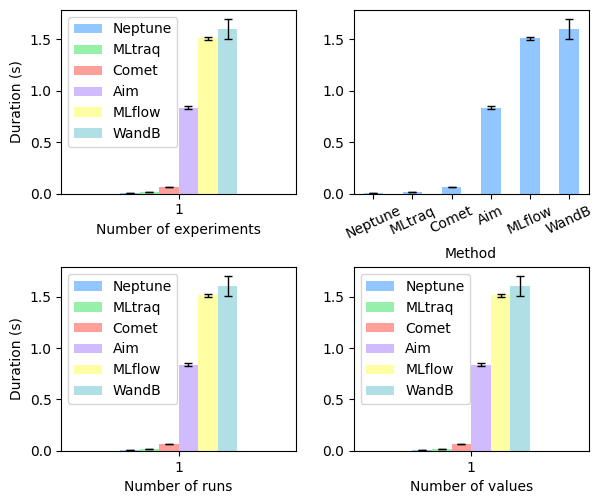


Averaged results by method



,duration,ratio_to_best
method,,
Neptune,0.003991,1.000000
MLtraq,0.014888,3.730412
Comet,0.063930,16.018993
Aim,0.836340,209.561778
MLflow,1.513362,379.203313
WandB,1.603758,401.853667


In [19]:
e = session.create_experiment("exp-1", if_exists="replace")
e.add_runs(
    method=["Aim", "Comet", "WandB", "Neptune", "MLtraq", "MLflow"],
    i=range(10),
    n_experiments=[1],
    n_runs=[1],
    n_values=[1],
)

# Parallelization is disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

# Report results
report_results(e)

The analysis of the test procedures with `pyinstrument` reveals where most of the time is spent for each method:

* WandB and MLflow are the worst performing, with time dominated by threading and events management.
* Aim follows by spending most of the time creating and managing the database.
* Comet is next, with threading management taking most of the time.
* MLtraq spends most of the time writing to SQLite, with no threading.
* Comet is the best performing, with no threading, no SQLite database, simply writing the tracking data to disk.

In summary, the less you do to start up, the faster you are. Threading and communication are expensive, as well as database management.

### Experiment 2: How much time to track 1K and 10K values?

  2%|1         | 1/60 [00:01<01:02,  1.06s/it]

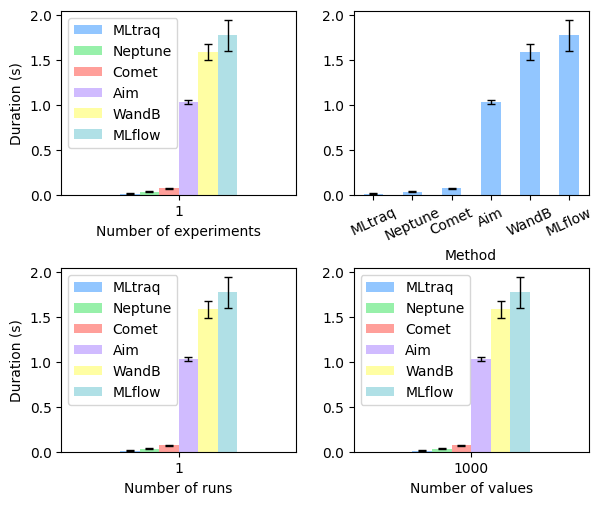


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.011883,1.000000
Neptune,0.033541,2.822443
Comet,0.069252,5.827576
Aim,1.032886,86.917617
WandB,1.581237,133.061590
MLflow,1.770706,149.005411


In [20]:
e = session.create_experiment("exp-2")
e.add_runs(
    method=["Aim", "Comet", "WandB", "Neptune", "MLtraq", "MLflow"],
    i=range(10),
    n_experiments=[1],
    n_runs=[1],
    n_values=[10**3],
)

# Parallelization disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

# Report results
report_results(e)

  2%|1         | 1/60 [00:04<03:56,  4.02s/it]

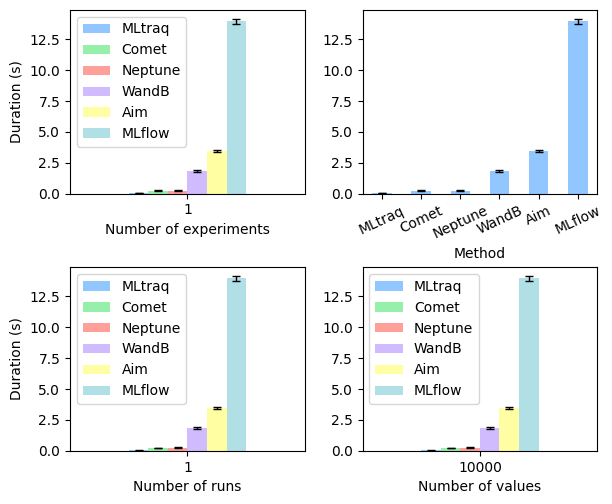


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.019677,1.000000
Comet,0.243711,12.385761
Neptune,0.249097,12.659470
WandB,1.840504,93.537219
Aim,3.480505,176.884569
MLflow,13.961461,709.542835


In [44]:
e = session.create_experiment("exp-2a")
e.add_runs(
    method=["Aim", "Comet", "WandB", "Neptune", "MLtraq", "MLflow"],
    i=range(10),
    n_experiments=[1],
    n_runs=[1],
    n_values=[10**4],
)

# Parallelization disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

# Report results
report_results(e)

* Performance changes dramatically, with WandB, MLflow and Aim being the worst performing, either due to thread communication (WandB, Aim) or database management (MLflow).
* Comet is next, followed by Neptune and MLtraq.

The advantage of MLtraq is in how the data is tracked and stored. Being very close to simply adding an element to an array and serializing it to an SQLite column value with the speedy DATAPAK serialization strategy, it is hard to beat.

### Experiment 3: How much time to track 10 runs?

  2%|1         | 1/60 [00:04<04:18,  4.38s/it]

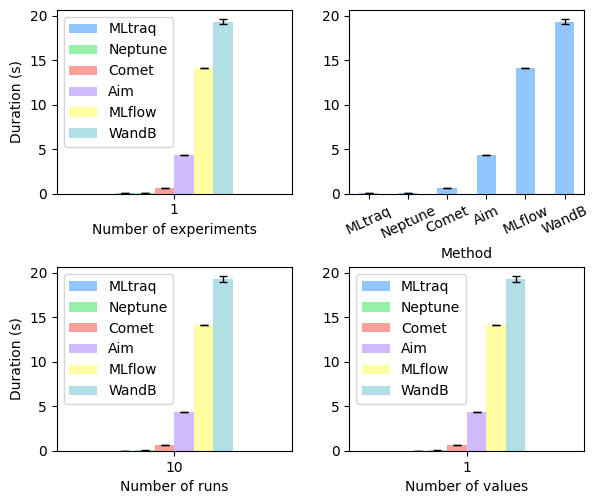


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.014656,1.000000
Neptune,0.025227,1.721236
Comet,0.642713,43.851759
Aim,4.342038,296.253423
MLflow,14.142685,964.942831
WandB,19.327106,1318.671334


In [21]:
e = session.create_experiment("exp-3")
e.add_runs(
    method=["Aim", "Comet", "WandB", "Neptune", "MLtraq", "MLflow"],
    i=range(10),
    n_experiments=[1],
    n_runs=[10],
    n_values=[1],
)

# Parallelization is disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

# Report results
report_results(e)

The results are very similar to Experiment 1, with MLtraq now performing at the top.

* Neptune and Comet use the filesystem as a database, and MLtraq uses SQLite. As the number of files written by Neptune/Comet increases, it becomes more expensive than writing efficiently to a single database file. Writing to a single SQLite file can be 35% faster than writing to many filesystem files. See https://www.sqlite.org/fasterthanfs.html for more details.

* Comet creates a ZIP of the files to be uploaded to their cloud, which results in an additional time penalty.



### Experiment 4: How much time to track 100 runs?

  3%|3         | 1/30 [00:00<00:00, 74.98it/s]

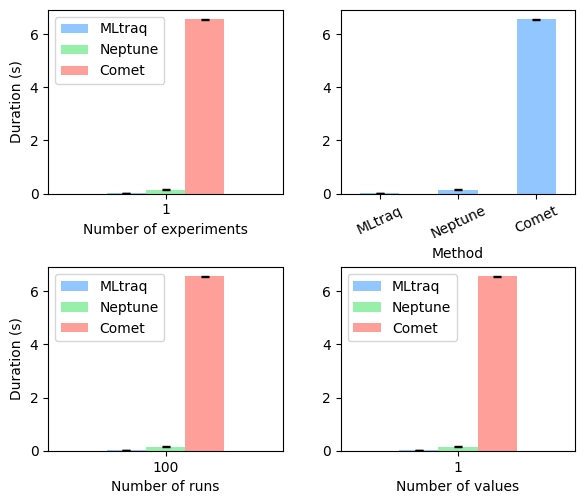


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.010299,1.000000
Neptune,0.153302,14.885578
Comet,6.561861,637.154272


In [22]:
e = session.create_experiment("exp-4")
e.add_runs(
    method=["Comet", "Neptune", "MLtraq"],
    i=range(10),
    n_experiments=[1],
    n_runs=[100],
    n_values=[1],
)

# Parallelization is disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

# Report results
report_results(e)

The results are very similar to Experiment 4. Creating a ZIP of the logs is very expensive for Comet. The other methods have been excluded as they are orders of magnitude slower.

### Experiment 5: How much time to track 1K runs and 1K values each?

  1%|1         | 1/80 [00:22<29:17, 22.25s/it]

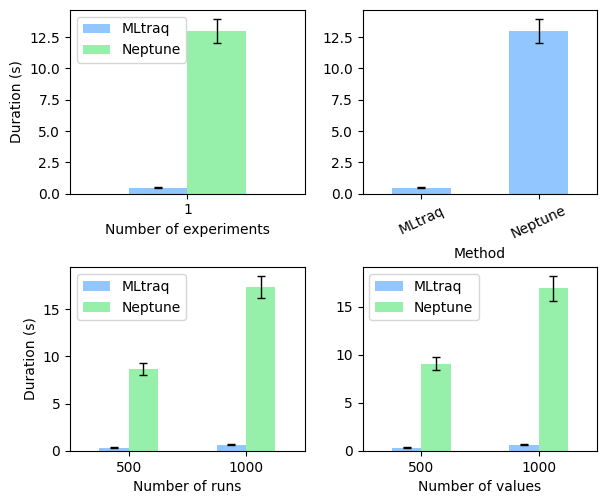


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.487075,1.000000
Neptune,13.001096,26.692186


In [24]:
e = session.create_experiment("exp-5")
e.add_runs(
    method=["Neptune", "MLtraq"],
    i=range(10),
    n_experiments=[1],
    n_runs=[500, 1000],
    n_values=[500, 1000],
)

# Parallelization is disabled as it might affect results.
e.execute([cleanup, eval_time, cleanup], n_jobs=1).persist(if_exists="replace")

# Report results
report_results(e)

* As we increase the number of tracked values or runs, MLtraq becomes more and more competitive. With no threading and no filesystem bottleneck, it is the fastest method for realistic workloads.
* With up to 1K runs and values, MLtraq is 25x faster than Neptune on average.
The other methods, WandB, Aim, Comet and MLflow, are orders of magnitude slower.

### Aggregates

In [39]:
dfs = [session.load(f"exp-{idx}").runs.df() for idx in [1, 2, 3, 4, 5]]
df = pd.concat(dfs).groupby("method").duration.mean().sort_values().to_frame()
df["ratio_to_best"] = df["duration"] / df["duration"].iloc[0]
df

,duration,ratio_to_best
method,,
MLtraq,0.250003,1.000000
Comet,1.834439,7.337660
Aim,2.070421,8.281576
MLflow,5.808918,23.235365
Neptune,6.527556,26.109879
WandB,7.504034,30.015741


### Save plots to SVG files

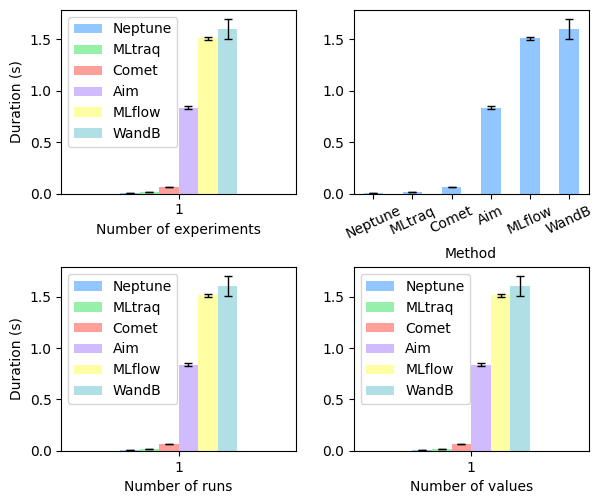


Averaged results by method



,duration,ratio_to_best
method,,
Neptune,0.003991,1.000000
MLtraq,0.014888,3.730412
Comet,0.063930,16.018993
Aim,0.836340,209.561778
MLflow,1.513362,379.203313
WandB,1.603758,401.853667


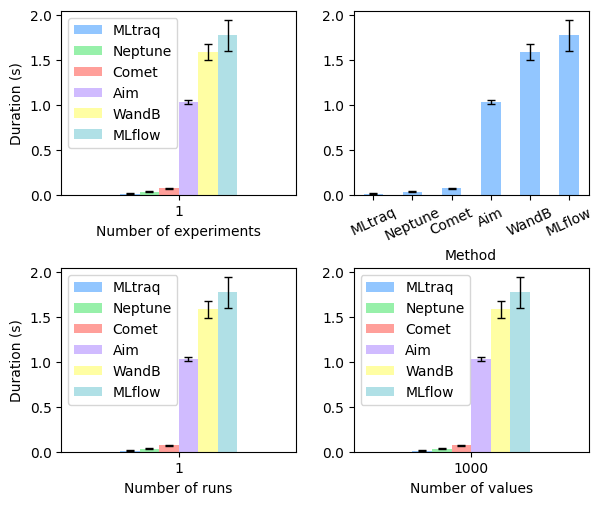


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.011883,1.000000
Neptune,0.033541,2.822443
Comet,0.069252,5.827576
Aim,1.032886,86.917617
WandB,1.581237,133.061590
MLflow,1.770706,149.005411


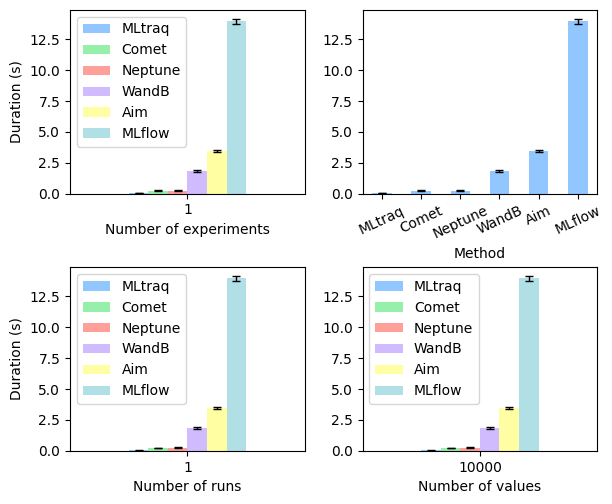


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.019677,1.000000
Comet,0.243711,12.385761
Neptune,0.249097,12.659470
WandB,1.840504,93.537219
Aim,3.480505,176.884569
MLflow,13.961461,709.542835


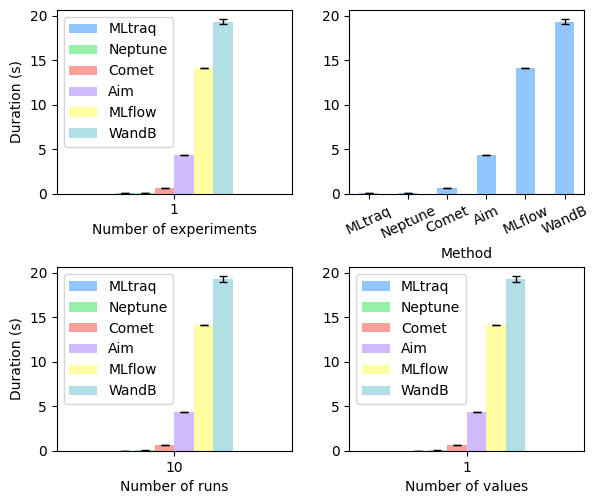


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.014656,1.000000
Neptune,0.025227,1.721236
Comet,0.642713,43.851759
Aim,4.342038,296.253423
MLflow,14.142685,964.942831
WandB,19.327106,1318.671334


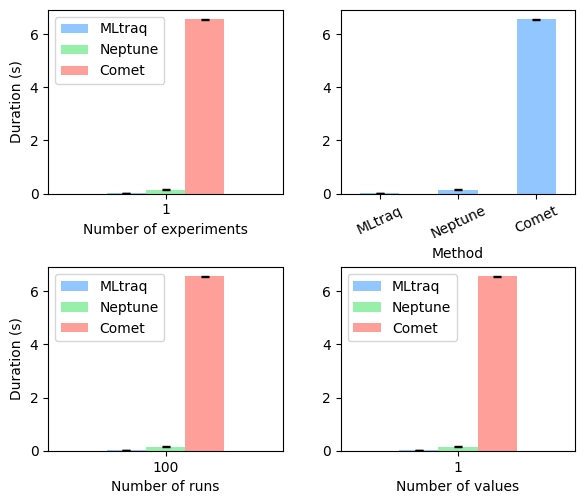


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.010299,1.000000
Neptune,0.153302,14.885578
Comet,6.561861,637.154272


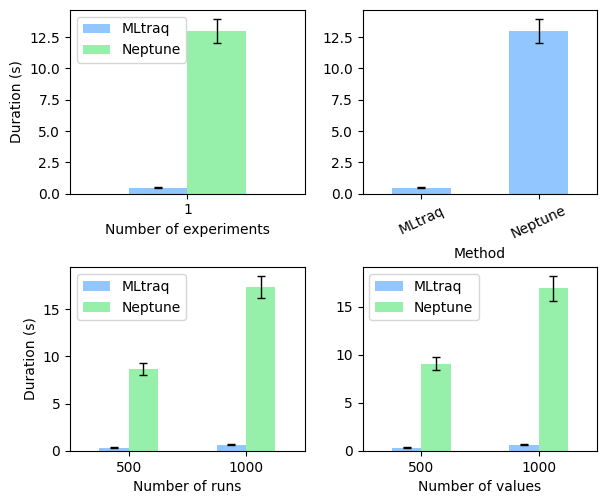


Averaged results by method



,duration,ratio_to_best
method,,
MLtraq,0.487075,1.000000
Neptune,13.001096,26.692186


In [45]:
# Create an MLtraq session to reload the benchmarks
session = mltraq.create_session("sqlite:///local/benchmarks.db")

# Save plots to SVG files
report_results(
    session.load("exp-1"),
    save_svg_to="../mkdocs/assets/img/benchmarks/exp-1.svg",
)
report_results(
    session.load("exp-2"),
    save_svg_to="../mkdocs/assets/img/benchmarks/exp-2.svg",
)
report_results(
    session.load("exp-2a"),
    save_svg_to="../mkdocs/assets/img/benchmarks/exp-2a.svg",
)
report_results(
    session.load("exp-3"),
    save_svg_to="../mkdocs/assets/img/benchmarks/exp-3.svg",
)
report_results(
    session.load("exp-4"),
    save_svg_to="../mkdocs/assets/img/benchmarks/exp-4.svg",
)
report_results(
    session.load("exp-5"),
    save_svg_to="../mkdocs/assets/img/benchmarks/exp-5.svg",
)

## Conclusion

In the experiments, MLtraq is, on average, 7-30x faster than the other methods. The benefits of MLtraq against the most popular choices on workloads with hundreds of thousands of runs and tracked values are even more accentuated and closer to 100x. If speed is among your priorities, you should consider MLtraq to run your experiments. The primary disadvantage of MLtraq is its lack of streaming of the tracking data and the missing web dashboard.
